In [2]:
import matplotlib.pyplot as plt
import pulp
import numpy as np
from pathlib import Path
import time as time_measure

from tools import computation
from tools import parameter_generator
from tools import online_learning
from tools import write_result

## Common parameters

In [3]:
p = 0.1
low = 10
up = 20
T = 50000
m = 4

# Plot of figure 8(b)

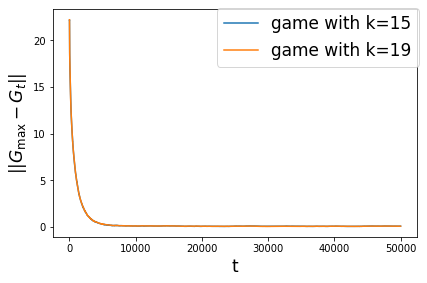

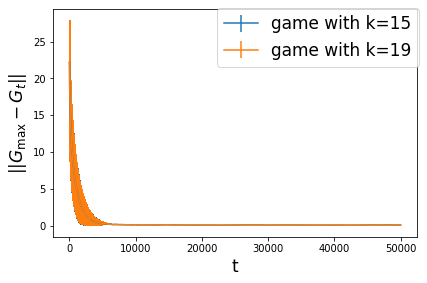

In [3]:
fig_dist, ax_dist = plt.subplots()
fig_error, ax_error = plt.subplots()

# Figure in the main paper: distance
list_dist = []
for k in [15, 19]:
    n = 2**k
    # Generate game parameters
    gain_success, loss_failure, CFA, PN = parameter_generator.random_vectors(
        n, m, low, up, 0)
    proba_attacker = parameter_generator.random_proba_attack(m, 0)
    filename = filename = 'equilibrium_parameters/solu_' + \
        str(k) + '_' + str(m) + '_' + str(p) + '_' + \
        str(low) + '_' + str(up) + '_' + str(0)
    # Retrieve equilibrium
    Geql, objective, time = write_result.read_eql(filename, m)
    for seed in range(10):
        # First the seed of the problem generated; then the seed of the online algorithm
        training_name = 'online_data/pb_' + str(k) + '_' + str(m) + '_' + str(
            p) + '_' + str(low) + '_' + str(up) + '_' + str(0) + '_' + str(seed) + '_' + str(T)
        if Path(training_name).is_file():
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_obj = write_result.read_online(
                training_name, T)
        else:
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol = \
                online_learning.online_algorithm(
                    p, proba_attacker, loss_failure, gain_success, CFA, PN, T, seed)
            write_result.write_online(
                list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol, training_name)
            optimal_obj = pulp.value(optimal_sol.objective)
        list_dist.append([online_learning.distance(Geql, list_G[i])
                          for i in range(T)])
    mean_dist = np.mean(list_dist, axis=0)
    std_dist = np.std(list_dist, axis=0)
    ax_dist.plot(range(1, T + 1), mean_dist, label='game with k=' + str(k))
    ax_error.errorbar(range(1, T + 1), mean_dist, std_dist,
                      label='game with k=' + str(k))

ax_dist.set_xlabel('t', fontsize=17)
ax_dist.set_ylabel(r'$||G_{\max} - G_t||$', fontsize=17)
fig_dist.legend(fontsize=17)
fig_dist.tight_layout()
fig_dist.savefig('plots/plot_online_distance.png', dpi=400)

ax_error.set_xlabel('t', fontsize=17)
ax_error.set_ylabel(r'$||G_{\max} - G_t||$', fontsize=17)
fig_error.legend(fontsize=17)
fig_error.tight_layout()
fig_error.savefig('plots/plot_online_distance_error.png', dpi=400)

# Plot of figure 8(a)

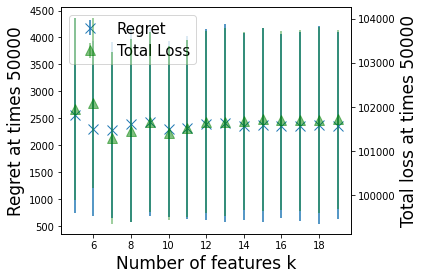

In [4]:
# Figure in the main paper: regret
list_regrets = [[] for k in range(5, 20)]
list_losses = [[] for k in range(5, 20)]
for k in range(5, 20):
    n = 2**k
    # Generate game parameters
    gain_success, loss_failure, CFA, PN = parameter_generator.random_vectors(
        n, m, low, up, 0)
    proba_attacker = parameter_generator.random_proba_attack(m, 0)
    filename = filename = 'equilibrium_parameters/solu_' + \
        str(k) + '_' + str(m) + '_' + str(p) + '_' + \
        str(low) + '_' + str(up) + '_' + str(0)
    # Retrieve equilibrium
    if(Path(filename).is_file()):
        Geql, objective, time = write_result.read_eql(filename, m)
    else:
        start = time_measure.time()
        bne_defender = computation.solve_defender(
            p, n, m, loss_failure, gain_success, PN, CFA, proba_attacker)
        end = time_measure.time()
        Geql = computation.retrieve_gain_eql(bne_defender, m)
        objective = pulp.value(bne_defender.objective)
        write_result.write_eql(Geql, objective, end - start, filename)
    for seed in range(10):
        # First the seed of the problem generated; then the seed of the online algorithm
        training_name = 'online_data/pb_' + str(k) + '_' + str(m) + '_' + str(
            p) + '_' + str(low) + '_' + str(up) + '_' + str(0) + '_' + str(seed) + '_' + str(T)
        if Path(training_name).is_file():
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_obj = write_result.read_online(
                training_name, T)
        else:
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol = \
                online_learning.online_algorithm(
                    p, proba_attacker, loss_failure, gain_success, CFA, PN, T, seed)
            write_result.write_online(
                list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol, training_name)
            optimal_obj = pulp.value(optimal_sol.objective)
        list_dist.append([online_learning.distance(Geql, list_G[i])
                          for i in range(T)])
        list_regrets[k - 5].append(loss_sum - optimal_obj)
        list_losses[k - 5].append(loss_sum)

mean_reg = [np.mean(list_regret) for list_regret in list_regrets]
std_reg = [np.std(list_regret) for list_regret in list_regrets]

mean_loss = [np.mean(list_loss) for list_loss in list_losses]
std_loss = [np.std(list_loss) for list_loss in list_losses]

fig_reg, ax_reg = plt.subplots()
x = range(5, 20)

ax_reg.set_xlabel("Number of features k", fontsize=17)
ax_reg.set_ylabel("Regret at times " + str(T), fontsize=17)
ax_reg.errorbar(x, mean_reg, std_reg, linestyle='None',
                marker='x', label='Regret', markersize=10.)

ax2 = ax_reg.twinx()
ax2.set_ylabel("Total loss at times " + str(T), fontsize=17)
ax2.errorbar(x, mean_loss, std_loss, linestyle='None', marker='^',
             label='Total Loss', color='g', alpha=0.5, markersize=10.)

h1, l1 = ax_reg.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax_reg.legend(h1 + h2, l1 + l2, loc=2, fontsize=15)

# Save the figure and show
plt.tight_layout()
plt.savefig('plots/regret_online.png')

# Plot of figure 9

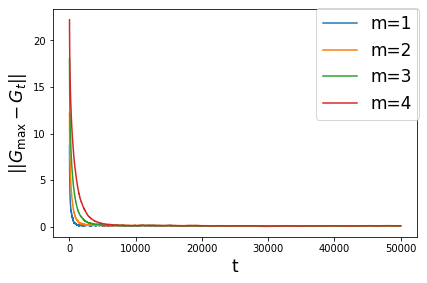

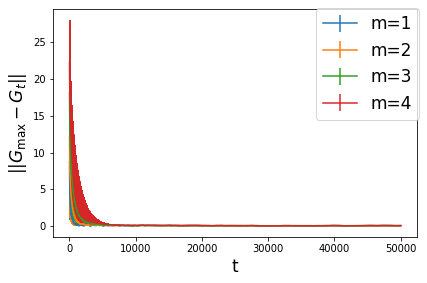

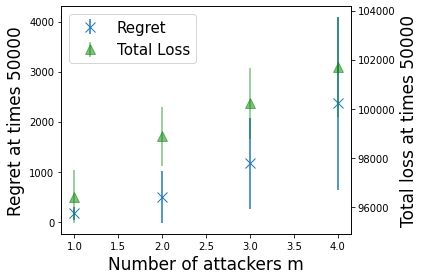

In [4]:
k = 19
n = 2**k
T = 50000

# Plot without error bars
fig_dist, ax_dist = plt.subplots()

# Plot with error bars
fig_error, ax_error = plt.subplots()

# Order of the file: k, m, p, low, up, seed
list_regrets = [[] for m in range(1, 5)]
list_losses = [[] for m in range(1, 5)]
bounds = []
for m in range(1, 5):
    list_dist = []
    gain_success, loss_failure, CFA, PN = parameter_generator.random_vectors(
        n, m, low, up, 0)
    proba_attacker = parameter_generator.random_proba_attack(m, 0)
    filename = filename = 'equilibrium_parameters/solu_' + \
        str(k) + '_' + str(m) + '_' + str(p) + '_' + \
        str(low) + '_' + str(up) + '_' + str(0)
    Geql, objective, time = write_result.read_eql(filename, m)
    # Computes the regret bound
    Gmin = [max([-loss_failure[j][v] for v in range(n)]) for j in range(m)]
    Gmax = [max(gain_success[j]) for j in range(m)]
    for seed in range(10):
        # First the seed of the problem generated; then the seed of the online algorithm
        training_name = 'online_data/pb_' + str(k) + '_' + str(m) + '_' + str(
            p) + '_' + str(low) + '_' + str(up) + '_' + str(0) + '_' + str(seed) + '_' + str(T)
        if Path(training_name).is_file():
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_obj = write_result.read_online(
                training_name, T)
        else:
            list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol = \
                online_learning.online_algorithm(
                    p, proba_attacker, loss_failure, gain_success, CFA, PN, T, seed)
            write_result.write_online(
                list_G, vectors_encountered, number_attackers, loss_sum, optimal_sol, training_name)
            optimal_obj = pulp.value(optimal_sol.objective)
        list_dist.append([online_learning.distance(Geql, list_G[i])
                          for i in range(T)])
        list_regrets[m - 1].append(loss_sum - optimal_obj)
        list_losses[m - 1].append(loss_sum)
    mean_dist = np.mean(list_dist, axis=0)
    std_dist = np.std(list_dist, axis=0)
    ax_dist.plot(range(1, T + 1), mean_dist, label='m=' + str(m))
    ax_error.errorbar(range(1, T + 1), mean_dist,
                      std_dist, label='m=' + str(m))

ax_dist.set_xlabel('t', fontsize=17)
ax_dist.set_ylabel(r'$||G_{\max} - G_t||$', fontsize=17)
fig_dist.legend(fontsize=17)
fig_dist.tight_layout()
fig_dist.savefig('plots/plot_online_distance_diff_m.png', dpi=400)

ax_error.set_xlabel('t', fontsize=17)
ax_error.set_ylabel(r'$||G_{\max} - G_t||$', fontsize=17)
fig_error.legend(fontsize=17)
fig_error.tight_layout()
fig_error.savefig('plots/plot_online_distance_diff_m_error.png', dpi=400)

mean_reg = [np.mean(list_regret) for list_regret in list_regrets]
std_reg = [np.std(list_regret) for list_regret in list_regrets]

mean_loss = [np.mean(list_loss) for list_loss in list_losses]
std_loss = [np.std(list_loss) for list_loss in list_losses]

fig_reg, ax_reg = plt.subplots()
x = range(1, 5)

ax_reg.set_xlabel("Number of attackers m", fontsize=17)
ax_reg.set_ylabel("Regret at times " + str(T), fontsize=17)
ax_reg.errorbar(x, mean_reg, std_reg, linestyle='None',
                marker='x', label='Regret', markersize=10.)

ax2 = ax_reg.twinx()
ax2.set_ylabel("Total loss at times " + str(T), fontsize=17)
ax2.errorbar(x, mean_loss, std_loss, linestyle='None', marker='^',
             label='Total Loss', color='g', alpha=0.5, markersize=10.)

h1, l1 = ax_reg.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax_reg.legend(h1 + h2, l1 + l2, loc=2, fontsize=15)

# Save the figure and show
plt.tight_layout()
plt.savefig('plots/regret_diff_m.png')
